# 협업 필터링
### : 사용자들의 행동 기반으로, 유사한 사용자나 항목들을 찾아서 추천을 수행하는 기법 <br>


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
import pandas as pd

# 데이터 살펴보기

###### (1) PP_recipes.csv
* id : Recipe ID
* i : Recipe ID mapped to contiguous integers from 0
* name_tokens : BPE-tokenized recipe name
```BPE 토크나이즈는 Byte Pair Encoding의 토큰화 방법을 의미하며, 단어를 하위 단위(subword)로 분리하는 방식```
* ingredient_tokens : BPE-tokenized ingredients list (list of lists)
* steps_tokens : BPE-tokenized steps (BPE 토크나이즈된 조리 단계)
* techniques : List of techniques used in recipe
* calorie_level : Calorie level in ascending order (0~2)
* ingredient_ids : IDs of ingredients in recipe (레시피에 포함된 재료들의 ID)

In [ ]:
raw_data_PP_recipes = pd.read_csv('../data/kaggle_Recipes/PP_recipes.csv')
raw_data_PP_recipes.head()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


###### (2) PP_users.csv
* u : User ID mapped to contiguous integer sequence from 0
* techniques : Cooking techniques encountered by user
* items : Recipes interacted with, in order
* n_items  : Number of recipes reviewed
* ratings : Ratings given to each recipe encountered by this user
* n_ratings : Number of ratings in total

In [ ]:
raw_data_PP_users = pd.read_csv('../data/kaggle_Recipes/PP_users.csv')
raw_data_PP_users.head()

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


###### (3) RAW_interactions.csv

In [ ]:
raw_data_RAW_interactions = pd.read_csv('../data/kaggle_Recipes/RAW_interactions.csv')
raw_data_RAW_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


### 레시피 데이터
##### 레시피 이름, 설명, 재료, 조리법 등

###### (4) RAW_recipes.csv
* name : Recipe name
* id : Recipe ID
* minutes : Minutes to prepare recipe
* nutrition : Nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat
* n_steps : Number of steps in recipe
* description : User-provided description

In [ ]:
raw_data_RAW_recipes = pd.read_csv('../data/kaggle_Recipes/RAW_recipes.csv')
raw_data_RAW_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [ ]:
raw_data_RAW_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


-------------

### interactions_ :
### Food.com 웹사이트 사용자들의 레시피에 대한 평가/리뷰 등 데이터
interactions_train:약 160,000개의 레시피 ID가 약 25,000명의 사용자 ID에 의해 약 699,000개의 레코드로 평가되는 데이터

In [ ]:
raw_data_interactions_test = pd.read_csv('../data/kaggle_Recipes/interactions_test.csv')
raw_data_interactions_test.head()

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


In [ ]:
raw_data_interactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12455 entries, 0 to 12454
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    12455 non-null  int64  
 1   recipe_id  12455 non-null  int64  
 2   date       12455 non-null  object 
 3   rating     12455 non-null  float64
 4   u          12455 non-null  int64  
 5   i          12455 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 584.0+ KB


In [ ]:
raw_data_interactions_train = pd.read_csv('../data/kaggle_Recipes/interactions_train.csv')
raw_data_interactions_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [ ]:
raw_data_interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


In [ ]:
raw_data_interactions_vaild = pd.read_csv('../data/kaggle_Recipes/interactions_validation.csv')
raw_data_interactions_vaild.head()

,user_id,recipe_id,date,rating,u,i
0,76535,33627,2005-02-15,4.0,5,177317
1,160497,75307,2005-10-24,4.0,23,170785
2,930021,100961,2008-11-30,4.0,31,165555
3,58439,154105,2007-03-24,4.0,44,177453
4,628951,14525,2008-02-16,5.0,45,142367


In [ ]:
raw_data_interactions_vaild.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    7023 non-null   int64  
 1   recipe_id  7023 non-null   int64  
 2   date       7023 non-null   object 
 3   rating     7023 non-null   float64
 4   u          7023 non-null   int64  
 5   i          7023 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 329.3+ KB


1. https://medium.com/web-mining-is688-spring-2021/a-recommendation-engine-for-the-recipes-by-using-collaborative-filtering-in-python-72171b52e7a2

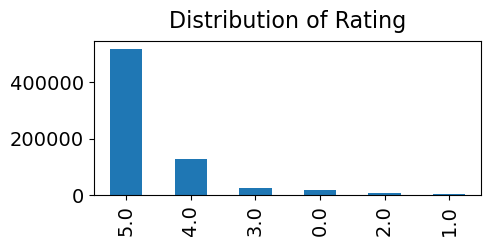

In [ ]:
# interactions_train.csv 평점 분포도 살펴보기


import matplotlib.pyplot as plt

raw_data_interactions_train.rating.value_counts().plot(kind = 'bar', fontsize = 14,
                             figsize = (5, 2)).set_title('Distribution of Rating',
                                                         fontsize = 16, ha = 'center', va = 'bottom')

plt.show()

In [ ]:
import pickle

with open('../data/kaggle_Recipes/ingr_map.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
data.head()

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308


-----------------

In [ ]:
_all = raw_data_interactions_train.drop(['date', 'u', 'i'], axis = 1)
_all

,user_id,recipe_id,rating
0,2046,4684,5.0
1,2046,517,5.0
2,1773,7435,5.0
3,1773,278,4.0
4,2046,3431,5.0
...,...,...,...
698896,926904,457971,5.0
698897,2002312797,27208,5.0
698898,1290903,131607,5.0
698899,226867,363072,5.0


In [ ]:
# 'user_id'를 기준으로 그룹화하여 각 사용자가 평가한 레시피 수를 집계
grouped_1 = _all.groupby(['user_id'], as_index = False, sort = False).agg({'recipe_id':'count'}).reset_index(drop = True)
grouped_1 = grouped_1.rename(columns = {'recipe_id':'reviews_count'})
grouped_1 = grouped_1.sort_values('reviews_count', ascending = False).iloc[:7500, :]

In [ ]:
grouped_1

,user_id,reviews_count
9980,424680,6437
575,37449,4581
9338,383346,3656
4264,169430,3465
3146,128473,3338
...,...,...
8361,308507,13
2096,71854,13
10093,99254,13
5853,228313,13


In [ ]:
# 'recipe_id'를 기준으로 그룹화하여 각 레시피가 받은 평가 수를 집계
grouped_2 = _all.groupby(['recipe_id'], as_index = False, sort = False).agg({'user_id':'count'}).reset_index(drop = True)
grouped_2 = grouped_2.rename(columns = {'user_id':'reviews_count'})

# 상위 7500개 레시피만
grouped_2 = grouped_2.sort_values('reviews_count', ascending = False).iloc[:7500, :]

In [ ]:
grouped_2

,recipe_id,reviews_count
2669,27208,1091
21058,89204,1075
3620,32204,897
5995,39087,894
18739,69173,787
...,...,...
63326,214917,14
48452,160457,14
20168,83642,14
42123,19766,14


In [ ]:
_part = pd.merge(_all.merge(grouped_1).drop(['reviews_count'], axis = 1), grouped_2).drop(['reviews_count'], axis = 1)

In [ ]:
#  상위 7,500명의 사용자와 상위 7,500개의 레시피로 구성된 샘플 데이터프레임

_part

,user_id,recipe_id,rating
0,2312,2886,5.0
1,11044,2886,5.0
2,9869,2886,5.0
3,22655,2886,3.0
4,26313,2886,4.0
...,...,...,...
222248,2198132,518229,5.0
222249,2209000,518229,5.0
222250,2200124,518229,5.0
222251,2192609,518229,5.0


In [ ]:
print('unique users:',len(_part.user_id.unique()))
print('unique recipes:',len(_part.recipe_id.unique()))

unique users: 7481
unique recipes: 7500


In [ ]:
# 'user_id'를 기준으로 그룹화하여 각 사용자가 평가한 레시피 수를 계산
grouped_user = _part.groupby(['user_id'], as_index = False, sort = False).agg({'recipe_id':'count'}).reset_index(drop = True)
grouped_user = grouped_user.rename(columns = {'recipe_id':'reviews_count'})

display(grouped_user[['reviews_count']].describe())

,reviews_count
count,7481.000000
mean,29.708996
std,49.227948
min,1.000000
25%,9.000000
50%,15.000000
75%,30.000000
max,1366.000000


In [ ]:
grouped_recipe = _part.groupby(['recipe_id'], as_index = False, sort = False).agg({'user_id':'count'}).reset_index(drop = True)
grouped_recipe = grouped_recipe.rename(columns = {'user_id':'reviews_count'})

display(grouped_recipe[['reviews_count']].describe())

,reviews_count
count,7500.000000
mean,29.633733
std,36.224671
min,5.000000
25%,15.000000
50%,19.000000
75%,30.000000
max,708.000000


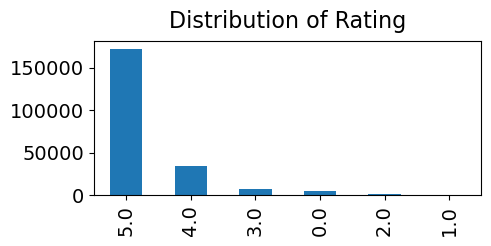

In [ ]:
import matplotlib.pyplot as plt

_part.rating.value_counts().plot(kind = 'bar', fontsize = 14,
                                 figsize = (5, 2)).set_title('Distribution of Rating',
                                                             fontsize = 16, ha = 'center', va = 'bottom')

plt.show()

In [ ]:
#  기존 사용자 ID와 새로운 ID를 매핑하는 딕셔너리 형태로 새로운 사용자 ID 할당

new_userID = dict(zip(list(_part['user_id'].unique()), # "user_id" 컬럼에서 중복을 제거
                      list(range(len(_part['user_id'].unique()))))) # 고유 사용자 ID 개수만큼의 길이를 갖는 정수 리스트를 생성 후 zip함수로 하나의 튜플 형태로 묶기(ex. (기존 사용자 ID, 새로운 ID))

display(new_userID)

{2312: 0,
 11044: 1,
 9869: 2,
 22655: 3,
 26313: 4,
 25455: 5,
 25792: 6,
 10033: 7,
 8688: 8,
 28397: 9,
 29014: 10,
 30209: 11,
 29063: 12,
 42058: 13,
 43505: 14,
 32772: 15,
 60989: 16,
 55589: 17,
 64583: 18,
 30228: 19,
 76074: 20,
 85714: 21,
 88717: 22,
 96436: 23,
 93997: 24,
 25941: 25,
 101376: 26,
 59588: 27,
 98919: 28,
 92641: 29,
 111347: 30,
 91584: 31,
 126104: 32,
 60716: 33,
 135887: 34,
 121852: 35,
 122175: 36,
 144671: 37,
 148715: 38,
 130513: 39,
 140806: 40,
 155675: 41,
 155595: 42,
 142386: 43,
 162086: 44,
 163601: 45,
 172369: 46,
 168087: 47,
 162725: 48,
 184081: 49,
 188119: 50,
 189475: 51,
 99221: 52,
 186979: 53,
 194611: 54,
 203111: 55,
 201064: 56,
 207375: 57,
 207176: 58,
 215350: 59,
 218535: 60,
 217226: 61,
 215260: 62,
 227039: 63,
 224088: 64,
 124268: 65,
 143721: 66,
 235074: 67,
 203741: 68,
 257993: 69,
 259154: 70,
 145130: 71,
 246482: 72,
 269891: 73,
 297557: 74,
 272300: 75,
 302961: 76,
 267665: 77,
 307059: 78,
 315635: 79,
 2582

In [ ]:
# 새로운 레시피 ID 할당
new_recipeID = dict(zip(list(_part['recipe_id'].unique()),
                        list(range(len(_part['recipe_id'].unique())))))

display(new_recipeID)

{2886: 0,
 3368: 1,
 11020: 2,
 9254: 3,
 13619: 4,
 15364: 5,
 15654: 6,
 14337: 7,
 18513: 8,
 20492: 9,
 16698: 10,
 33454: 11,
 37490: 12,
 31639: 13,
 18487: 14,
 45539: 15,
 35779: 16,
 35547: 17,
 52840: 18,
 61718: 19,
 19901: 20,
 75817: 21,
 14359: 22,
 39911: 23,
 86868: 24,
 65131: 25,
 106251: 26,
 109283: 27,
 21761: 28,
 132411: 29,
 109006: 30,
 202935: 31,
 239592: 32,
 200008: 33,
 5478: 34,
 55680: 35,
 24709: 36,
 79462: 37,
 17300: 38,
 55394: 39,
 53767: 40,
 83287: 41,
 51235: 42,
 37638: 43,
 118475: 44,
 30018: 45,
 70224: 46,
 63750: 47,
 57033: 48,
 90822: 49,
 213535: 50,
 2713: 51,
 17222: 52,
 3400: 53,
 19596: 54,
 24685: 55,
 4368: 56,
 40621: 57,
 8599: 58,
 12668: 59,
 29184: 60,
 18651: 61,
 18829: 62,
 23116: 63,
 19590: 64,
 23195: 65,
 25254: 66,
 11489: 67,
 33386: 68,
 30864: 69,
 21256: 70,
 50342: 71,
 37037: 72,
 37199: 73,
 51919: 74,
 67777: 75,
 45940: 76,
 30644: 77,
 38305: 78,
 27809: 79,
 59183: 80,
 47413: 81,
 29493: 82,
 46597: 83,
 

In [ ]:
df = _part.replace({'user_id': new_userID, 'recipe_id': new_recipeID})

In [ ]:
df

,user_id,recipe_id,rating
0,0,0,5.0
1,1,0,5.0
2,2,0,5.0
3,3,0,3.0
4,4,0,4.0
...,...,...,...
222248,7465,7499,5.0
222249,7475,7499,5.0
222250,7469,7499,5.0
222251,7472,7499,5.0


In [ ]:
# name 컬럼 r값이 없는 레시피들의 "id" 컬럼을 선택 후 .values[0]을 통해 id 컬럼에서 누락된 레시피 id값 추출
## raw_data_RAW_recipes['name'].isnull() : name 컬럼에서 누락된 레시피면 NaN값 들어감 -> isnaull 함수로 불리언 시리즈 생성
## raw_data_RAW_recipes['id'][raw_data_RAW_recipes['name'].isnull()] : raw_data_RAW_recipes['name'].isnull()에서 True로 나온 레시피의 id값 가져옴
## .values로 넘파이 배열로 변환 후 첫번째 요소([0]) 출력(name컬럼에서 누락된 레시피 중 첫 번째 레시피 id 출력)

print('The recipes without names: ', raw_data_RAW_recipes['id'][raw_data_RAW_recipes['name'].isnull()].values[0])
display(df[df['recipe_id'] == raw_data_RAW_recipes['id'][raw_data_RAW_recipes['name'].isnull()].values[0]])

The recipes without names:  368257


,user_id,recipe_id,rating


In [ ]:
recipe = raw_data_RAW_recipes[['name', 'id', 'ingredients']].merge(_part[['recipe_id']],
                                                left_on = 'id', right_on = 'recipe_id',
                                                how = 'right').drop(['id'], axis = 1).drop_duplicates().reset_index(drop = True)
recipe

,name,ingredients,recipe_id
0,best banana bread,"['butter', 'granulated sugar', 'eggs', 'banana...",2886
1,blackberry pie iii,"['sugar', 'all-purpose flour', 'cornstarch', '...",3368
2,casablanca chicken,"['boneless skinless chicken breasts', 'olive o...",11020
3,grilled salmon,"['fresh salmon', 'butter', 'garlic', 'salt', '...",9254
4,homemade pie crust,"['all-purpose flour', 'salt', 'butter', 'cold ...",13619
...,...,...,...
7495,cheesy potato italian sausage balls 5fix,['simply potatoes traditional mashed potatoes'...,496573
7496,cheddar stuffed potato cake and egg 5fix,"['olive oil', 'simply potatoes traditional mas...",497382
7497,quick and easy crabby caesar salads 5fix,"['complete caesar salad in a bag', 'simply pot...",497261
7498,mac n cheese and spinach strata sp5,"['simply macaroni & cheese', 'frozen spinach',...",514423


In [ ]:
print('unique users:',len(_part.user_id.unique()))
print('unique recipes:',len(_part.recipe_id.unique()))

unique users: 7481
unique recipes: 7500


In [ ]:
df

,user_id,recipe_id,rating
0,0,0,5.0
1,1,0,5.0
2,2,0,5.0
3,3,0,3.0
4,4,0,4.0
...,...,...,...
222248,7465,7499,5.0
222249,7475,7499,5.0
222250,7469,7499,5.0
222251,7472,7499,5.0


In [ ]:
# 사용자별로 레시피 평균 평점 계산
mean = df.groupby(['user_id'], as_index = False, sort = False).mean().rename(columns = {'rating':'rating_mean'})
# as_index : 인덱스를 기준으로 그룹화하지 않고 기존 'user_id' 컬럼 유지

df = df.merge(mean[['user_id','rating_mean']], how = 'left')
df.insert(2, 'rating_adjusted', df['rating'] - df['rating_mean']) # 2번 인덱스(3번째) 위치에 넣어라
df

,user_id,recipe_id,rating_adjusted,rating,rating_mean
0,0,0,0.382353,5.0,4.617647
1,1,0,0.304348,5.0,4.695652
2,2,0,0.088319,5.0,4.911681
3,3,0,-1.031250,3.0,4.031250
4,4,0,-0.692308,4.0,4.692308
...,...,...,...,...,...
222248,7465,7499,0.588235,5.0,4.411765
222249,7475,7499,0.000000,5.0,5.000000
222250,7469,7499,0.357143,5.0,4.642857
222251,7472,7499,0.384615,5.0,4.615385


In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.25)
display(train_data)
display(test_data)

,user_id,recipe_id,rating_adjusted,rating,rating_mean
184661,400,5448,0.285714,5.0,4.714286
40256,5261,694,0.000000,5.0,5.000000
146409,3982,3888,0.526316,5.0,4.473684
27251,6030,472,1.000000,5.0,4.000000
113838,1527,2816,-0.452055,4.0,4.452055
...,...,...,...,...,...
28639,548,482,0.363636,5.0,4.636364
30192,146,505,-0.561404,4.0,4.561404
63182,4588,1369,0.157895,5.0,4.842105
115992,4418,2871,0.200000,5.0,4.800000


,user_id,recipe_id,rating_adjusted,rating,rating_mean
45392,1052,874,0.165217,5.0,4.834783
200133,1606,6205,0.090909,5.0,4.909091
3830,806,90,-2.691176,2.0,4.691176
21095,34,370,0.905882,5.0,4.094118
146119,1779,3882,-0.142857,4.0,4.142857
...,...,...,...,...,...
36050,6299,572,-4.100000,0.0,4.100000
115049,770,2845,0.698630,5.0,4.301370
157472,986,4298,0.293103,5.0,4.706897
116464,1297,2887,-0.961538,4.0,4.961538


In [ ]:
# 평점 매트릭스 생성

## # train 데이터로 평저 ㅁ매트릭스 생성

n_users = df.user_id.unique()
n_items = df.recipe_id.unique()
## 사용자 ID와 레시피 ID의 고유한 값들을 추출하여 나중에 평점 매트릭스를 생성하는데 사용하는 이유는
## 평점 매트릭스의 크기를 결정하기 위해서
##  -> 평점 매트릭스는 사용자의 수와 레시피의 수에 따라 크기가 달라지기 때문에, 먼저 고유의 사용자 ID와 레시피 ID의 개수를 구하여 이를 기반으로 평점 매트릭스의 크기를 설정함.
##  이렇게 함으로써 데이터프레임의 크기에 관계없이 유동적으로 평점 매트릭스를 생성할 수 있음.


train_data_matrix = np.zeros((n_users.shape[0], n_items.shape[0])) # 모든 원소가 0인 행렬을 생성
for row in train_data.itertuples():
    train_data_matrix[row[1]-1, row[2]-1] = row[3]
    #각 행의 사용자 ID (row[1])와 레시피 ID (row[2])를 이용하여 평점 매트릭스의 해당 위치에 해당하는 원소에 평점 (row[3])을 할당
    # 여기서 row[1]과 row[2]는 1부터 시작하는 인덱스이므로 0부터 시작하는 인덱스로 변경하기 위해 각각 1씩 빼줌.

display(train_data_matrix.shape)
display(train_data_matrix)

(7481, 7500)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.30434783],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.08831909],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.03125   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38235294,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# test 데이터로 평저 ㅁ매트릭스 생성

test_data_matrix = np.zeros((n_users.shape[0], n_items.shape[0]))
for row in test_data.itertuples():
    test_data_matrix[row[1]-1, row[2]-1] = row[3]

display(test_data_matrix.shape)
display(test_data_matrix)

(7481, 7500)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38235294, 0.38235294, ..., 0.        , 0.        ,
        0.38235294]])

* 사용자의 수와 레시피의 수에 따라 매트릭스의 크기가 결정되기 때문에, train_data_matrix와 test_data_matrix의 크기가 같을 수 있음 <br>
so, (7481, 7500) : 사용자의 수가 7481명,ㄹ ㅔ시피의 수가 7500개

### 코사인 유사도
##### CF에서 사용자 간의 유사도를 구할 때 사용하는 지표

In [ ]:
# pairwise_distances : 주어진 데이터의 쌍(pair) 간의 거리나 유사도를 계산하는 함수
# train_data_matrix : 사용자의 수를 행, 레시피의 수를 열로 갖는 매트릭스
user_similarity = 1 - pairwise_distances(train_data_matrix, metric = 'cosine')

display(user_similarity.shape)
display(user_similarity)

(7481, 7481)

array([[ 1.        , -0.00498782, -0.01922596, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00498782,  1.        , -0.01706556, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01922596, -0.01706556,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

pairwise_distances는 주어진 데이터의 쌍(pair) 간의 거리나 유사도를 계산하는 함수이므로 대칭 행렬로 표현해야해서 shape이 7481,7481이 됨

In [ ]:
# 레시피를 행으로, 사용자를 열로 나타내는게 계산에 용이/적합하다고 한다...

item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric = 'cosine')

display(item_similarity.shape)
display(item_similarity)

(7500, 7500)

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.        , -0.01714598],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.52440815,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.52440815,
         1.        ,  0.        ],
       [ 0.        , -0.01714598,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

### 예측하기

In [ ]:
# _type 인자에 'user'를 지정하면 사용자 기반 협업 필터링을 수행하고, 'item'을 지정하면 아이템 기반 협업 필터링을 수행
# (1) 사용자 기반 CF : 사용자 간의 유사도를 이용하여 사용자에게 추천을 제공하는 방법
# : 유사한 평가 패턴을 가진 사용자들끼리 클러스터링 하여 특성 파악

def predict(ratings, similarity, _type = 'user'):
    if _type == 'user':
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis = np.newaxis)])

    elif _type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)])

    return pred

In [ ]:
user_pred = predict(train_data_matrix, user_similarity, _type = 'user')

display(user_pred.shape)
display(user_pred)

(7481, 7500)

array([[-4.10759005e-08, -1.04991909e-07, -1.17158557e-07, ...,
         0.00000000e+00,  0.00000000e+00,  3.48535780e-05],
       [ 1.12647724e-06,  1.71194365e-07, -9.77629809e-08, ...,
         0.00000000e+00,  0.00000000e+00,  3.12873163e-06],
       [ 1.73339723e-08, -3.40196417e-08, -1.21514712e-07, ...,
         0.00000000e+00,  0.00000000e+00, -2.15674300e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.23211311e-06, -1.27080436e-08,  1.11613794e-06, ...,
         0.00000000e+00,  0.00000000e+00, -6.95765187e-08]])

In [ ]:
# 사용자 기반 CF를 통해 예측된 사용자별 레시피 평점 데이터프레임화

user_pred_df = pd.DataFrame(user_pred, columns = list(n_items)) # n_items는 훈련 데이터에 있는 모든 레시피 ID들의 목록
user_pred_df.insert(0, 'user_id', list(n_users))

user_pred_df

,user_id,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-4.107590e-08,-1.049919e-07,-1.171586e-07,-2.339807e-07,-1.947962e-08,4.619098e-07,-7.343241e-08,3.625399e-08,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.485358e-05
1,1,1.126477e-06,1.711944e-07,-9.776298e-08,-4.295555e-08,-1.109751e-07,-2.521522e-07,-2.879239e-08,6.061423e-09,-9.462653e-09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.128732e-06
2,2,1.733397e-08,-3.401964e-08,-1.215147e-07,-8.613912e-07,9.612547e-08,-1.288207e-07,1.541744e-06,3.423085e-08,7.480327e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.156743e-05
3,3,1.239121e-07,3.018074e-07,-2.665213e-08,2.008356e-07,1.613049e-09,-2.109628e-07,-1.795205e-07,-4.348337e-08,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.997914e-05
4,4,2.067664e-08,5.651415e-08,-4.869929e-08,6.844553e-08,-2.228057e-07,1.616986e-07,4.694515e-07,5.773327e-08,4.713688e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.606638e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,7476,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7477,7477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.906622e-08,1.461030e-06,0.000000e+00,0.000000e+00,...,0.000004,0.000004,-0.000007,0.000006,0.000016,0.000002,0.000002,0.000004,0.000002,0.000000e+00
7478,7478,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7479,7479,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [ ]:
# (2) 레시피 기반 CF : 레시피 간의 유사도를 이용하여 레시피에 추천을 제공하는 방법
# : 각 레시피를 기준으로 다른 레시피들과의 유사도를 계산하여 레시피들을 클러스터링하고, (ex. 재료, 조리법 등등이나 사용자의 평가 패턴)
# 이를 통해 사용자들이 해당 레시피에 대해 예상하는 평점을 예측(사용자들이 아직 평가하지 않은 레시피에 대해 예상 평점을 예측)
# Ex.사용자 A가 높은 평점을 준 레시피들과 유사한 레시피들은, 해당 레시피들에 대해 사용자 A가 높은 평점을 줄 것으로 예상
item_pred = predict(train_data_matrix, item_similarity, _type = 'item')

display(item_pred.shape)
display(item_pred)

(7481, 7500)

array([[-7.16352391e-04, -6.70334157e-05, -4.15229931e-04, ...,
         0.00000000e+00,  0.00000000e+00,  9.76965459e-03],
       [ 9.40989610e-03,  5.25850055e-03, -4.06098027e-03, ...,
         0.00000000e+00,  0.00000000e+00,  2.67521882e-03],
       [-3.35308638e-03, -4.33395512e-03, -2.71176935e-03, ...,
         0.00000000e+00,  0.00000000e+00, -8.36357225e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.00124555e-02, -3.32462810e-04,  3.73472211e-03, ...,
         0.00000000e+00,  0.00000000e+00, -2.40768896e-04]])

In [ ]:
# 레시피 기반 CF를 통해 예측된 레시피별 사용자 평점 데이터프레임화

item_pred_df = pd.DataFrame(item_pred, columns = list(n_items))
item_pred_df.insert(0, 'user_id', list(n_users))

item_pred_df

,user_id,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-0.000716,-0.000067,-0.000415,-0.000334,0.000008,0.000353,-0.000185,0.000979,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009770
1,1,0.009410,0.005259,-0.004061,-0.001577,-0.000688,-0.002259,-0.001200,-0.000126,-0.000836,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002675
2,2,-0.003353,-0.004334,-0.002712,0.000128,-0.000404,-0.000263,0.011406,-0.002550,0.008939,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.083636
3,3,0.002236,0.002719,-0.000030,0.000089,-0.000085,0.000388,-0.000049,-0.000290,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018902
4,4,-0.000257,0.003250,0.003127,-0.001168,-0.008345,0.003082,0.001909,-0.000470,0.001871,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,7476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7477,7477,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000076,0.001255,0.000000,0.000000,...,0.026152,0.043782,-0.063426,0.072653,0.105887,0.023001,0.029967,0.025576,0.004254,0.000000
7478,7478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7479,7479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 평가

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
# 예측값과 실제값의 차이를 평가하는 지표 RMSE(Root Mean Squared Error)함수 만들기

def RMSE(prediction, ground_truth): # 예측값, 실제값
    prediction = prediction[ground_truth.nonzero()].flatten() # nonzero():0이 아닌 값의 인덱스 반환하는 함수
    ground_truth = ground_truth[ground_truth.nonzero()].flatten() # flatten():다차원 배열을 1차원 배열로 평평하게

    return sqrt(mean_squared_error(prediction, ground_truth)) # mean_squared_error() 함수를 통해 예측값과 실제값 사이의 평균 제곱 오차를 계산하고, 루트 씌워준 후 반환

In [ ]:
user_RMSE = RMSE(user_pred, test_data_matrix)
item_RMSE = RMSE(item_pred, test_data_matrix)

print('user_RMSE = {}'.format(user_RMSE))
print('item_RMSE = {}'.format(item_RMSE))

user_RMSE = 0.858486047088508
item_RMSE = 0.8584872799804456


실제값과 예측값의 차이를 평균으로 내서 그 값들을 제곱한 후, 제곱 평균값에 루트를 씌운 값이므로 0.858~은 매우 낮은 수치 => 모델의 예측 성능이 매우 좋다

### 추천 엔진

In [ ]:
user_pred_df

,user_id,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-4.107590e-08,-1.049919e-07,-1.171586e-07,-2.339807e-07,-1.947962e-08,4.619098e-07,-7.343241e-08,3.625399e-08,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.485358e-05
1,1,1.126477e-06,1.711944e-07,-9.776298e-08,-4.295555e-08,-1.109751e-07,-2.521522e-07,-2.879239e-08,6.061423e-09,-9.462653e-09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.128732e-06
2,2,1.733397e-08,-3.401964e-08,-1.215147e-07,-8.613912e-07,9.612547e-08,-1.288207e-07,1.541744e-06,3.423085e-08,7.480327e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.156743e-05
3,3,1.239121e-07,3.018074e-07,-2.665213e-08,2.008356e-07,1.613049e-09,-2.109628e-07,-1.795205e-07,-4.348337e-08,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.997914e-05
4,4,2.067664e-08,5.651415e-08,-4.869929e-08,6.844553e-08,-2.228057e-07,1.616986e-07,4.694515e-07,5.773327e-08,4.713688e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.606638e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,7476,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7477,7477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.906622e-08,1.461030e-06,0.000000e+00,0.000000e+00,...,0.000004,0.000004,-0.000007,0.000006,0.000016,0.000002,0.000002,0.000004,0.000002,0.000000e+00
7478,7478,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7479,7479,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [ ]:
# 입력한 사용자 ID를 기반으로 해당 사용자와 유사한 다른 사용자들을 찾아서 레시피를 추천하는
def getRecommendations_UserBased(user_id, top_n = 10): # 함수 호출시 top_n을 지정하지 않으면 기본값으로 10 적용해라
    # 사용자 기반 CF을 수행하기 위해, 입력한 사용자 ID가 이전 데이터셋에서 어떤 사용자 ID에 해당하는지를 확인하는 역할
    for old_user, new_user in new_userID.items(): # old_user:이전 데이터셋의 사용자 ID, new_user:새로운 데이터셋의 사용자 ID
        if user_id == new_user:
            print(f'Top {top_n} Recommended Recipes for Original User ID: {old_user}\n')

    movie_rated = list(df['recipe_id'].loc[df['user_id'] == user_id]) #df의 'user_id'가 user_id와 일치하는 행들 중에 'recipe_id' 열만 선택. 해당 사용자가 이미 평가한 레시피의 ID들을 리스트로 추출
    _all = user_pred_df.loc[user_pred_df['user_id'] == user_id].copy() # 입력한 사용자 ID에 해당하는 사용자별 레시피 평점 가져옴
    _all.drop(user_pred_df[movie_rated], axis = 1, inplace = True) # 이미 평가된 레시피를 제외하고 추천할 레시피만 남도록 데이터프레임을 수정
    unwatch_sorted = _all.iloc[:,1:].sort_values(by = _all.index[0], axis = 1, ascending = False) # 사용자가 아직 평가하지 않은 레시피 중 예측 평점이 높은 순서로 정렬하여 추천할 레시피 목록을 생성
    dict_top_n = unwatch_sorted.iloc[:, :top_n].to_dict(orient = 'records') # 상위 N개의 추천 레시피를 딕셔너리 형태로 생성하여 반환
    # ㄴorient 매개변수:딕셔너리로 변환하는 방식 지정(records는 데이터프레임의 각 행을 딕셔너리로 변환)

    i = 1
    for recipe_id in list(dict_top_n[0].keys()):
        for old_recipe, new_recipe in new_recipeID.items():
            if recipe_id == new_recipe:
                name = recipe[recipe['recipe_id'] == old_recipe]['name'].values[0]
                ingredients = recipe[recipe['recipe_id'] == old_recipe]['ingredients'].values[0]

                print(f'Top {i} Original Recipe ID: {old_recipe} - {name}\n Ingredients: {ingredients}\n')

                i += 1

    return dict_top_n[0]

In [ ]:
# 702번 사용자에게 어떤 레시피를 추천하는지 확인
R1_UserBased = getRecommendations_UserBased(702)
R1_UserBased

Top 10 Recommended Recipes for Original User ID: 318028

Top 1 Original Recipe ID: 37494 - savory pork chops
 Ingredients: ['all-purpose flour', 'ground mustard', 'seasoning salt', 'pepper', 'pork chops', 'vegetable oil', 'water', 'onion', 'ketchup', 'orange marmalade', 'soy sauce', 'dijon mustard']

Top 2 Original Recipe ID: 34713 - awesome  and economical  chai concentrate
 Ingredients: ['ground cardamom', 'ground ginger', 'cinnamon', 'ground cloves', 'ground nutmeg', 'condensed milk', 'strong black tea']

Top 3 Original Recipe ID: 39911 - grilled balsamic london broil
 Ingredients: ['top round steak', 'olive oil', 'balsamic vinegar', 'gluten-free soy sauce', 'dried thyme', 'garlic powder', 'black pepper']

Top 4 Original Recipe ID: 106826 - breakfast in a pan frittata
 Ingredients: ['olive oil', 'red skin white potato', 'red bell pepper', 'green onions', 'sliced mushrooms', 'canadian bacon', 'egg substitute', 'milk', 'mozzarella cheese', 'salt and pepper']

Top 5 Original Recipe ID:

{87: 3.235343680263703e-05,
 2637: 1.135574452517238e-05,
 23: 7.898266011805409e-06,
 1154: 6.9817900538374835e-06,
 5601: 4.78262579360911e-06,
 1589: 4.7813077407944356e-06,
 375: 4.461880360961496e-06,
 5422: 3.419687729052141e-06,
 1163: 3.334587104200491e-06,
 1453: 3.2610021730815984e-06}

In [ ]:
item_pred_df

,user_id,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-0.000716,-0.000067,-0.000415,-0.000334,0.000008,0.000353,-0.000185,0.000979,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009770
1,1,0.009410,0.005259,-0.004061,-0.001577,-0.000688,-0.002259,-0.001200,-0.000126,-0.000836,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002675
2,2,-0.003353,-0.004334,-0.002712,0.000128,-0.000404,-0.000263,0.011406,-0.002550,0.008939,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.083636
3,3,0.002236,0.002719,-0.000030,0.000089,-0.000085,0.000388,-0.000049,-0.000290,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018902
4,4,-0.000257,0.003250,0.003127,-0.001168,-0.008345,0.003082,0.001909,-0.000470,0.001871,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,7476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7477,7477,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000076,0.001255,0.000000,0.000000,...,0.026152,0.043782,-0.063426,0.072653,0.105887,0.023001,0.029967,0.025576,0.004254,0.000000
7478,7478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7479,7479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# 입력한 사용자 ID를 기반으로 해당 사용자와 유사한 다른 사용자들을 찾아서 레시피를 추천하는

def getRecommendations_ItemBased(recipe_id, top_n=10):
    for old_recipe, new_recipe in new_recipeID.items():
        if recipe_id == new_recipe:
            print(f'Top {top_n} Recommended Recipes for Original Recipe ID: {old_recipe}\n')

    user_rated = list(df['user_id'].loc[df['recipe_id'] == recipe_id])
    _all = item_pred_df.loc[item_pred_df['user_id'] == recipe_id].copy()
    _all.drop(item_pred_df[user_rated], axis=1, inplace=True)
    unwatch_sorted = _all.sort_values(by=_all.index[0], axis=1, ascending=False)
    dict_top_n = unwatch_sorted.iloc[:, 1:top_n+1].to_dict(orient='records')

    i = 1
    for recipe_id in list(dict_top_n[0].keys()):
        for old_recipe, new_recipe in new_recipeID.items():
            if recipe_id == new_recipe:
                name = recipe[recipe['recipe_id'] == old_recipe]['name'].values[0]
                ingredients = recipe[recipe['recipe_id'] == old_recipe]['ingredients'].values[0]

                print(f'Top {i} Original Recipe ID: {old_recipe} - {name}\n Ingredients: {ingredients}\n')
                i += 1

    return dict_top_n[0]

In [ ]:
R1_ItemBased = getRecommendations_ItemBased(702)
R1_ItemBased

Top 10 Recommended Recipes for Original Recipe ID: 5453

Top 1 Original Recipe ID: 34713 - awesome  and economical  chai concentrate
 Ingredients: ['ground cardamom', 'ground ginger', 'cinnamon', 'ground cloves', 'ground nutmeg', 'condensed milk', 'strong black tea']

Top 2 Original Recipe ID: 104700 - peppermint christmas cookies
 Ingredients: ['butter', 'icing sugar', 'egg', 'vanilla', 'peppermint extract', 'salt', 'green food coloring', 'flour', 'hershey chocolate kisses']

Top 3 Original Recipe ID: 1356 - ground beef stuffed green bell peppers with cheese
 Ingredients: ['green peppers', 'beef', 'onion', 'tomatoes', 'long grain rice', 'water', 'salt', 'worcestershire sauce', 'cheddar cheese']

Top 4 Original Recipe ID: 33995 - vegan truffles
 Ingredients: ['raw cashews', 'water', 'bittersweet chocolate', 'cocoa powder']

Top 5 Original Recipe ID: 9054 - leftover mashed potato pancakes
 Ingredients: ['mashed potatoes', 'egg', 'flour', 'salt', 'pepper', 'garlic', 'onion', 'chives', 'c

{2637: 0.06721948813574986,
 5422: 0.053209568675433444,
 1000: 0.048360005072782805,
 5698: 0.045342247120675874,
 6063: 0.042997276312974037,
 1163: 0.030044847542985427,
 1589: 0.025904984284268566,
 5357: 0.024927023786940686,
 6699: 0.024344191279773438,
 1474: 0.019841030787123938}